In [74]:
#pip install seaborn

In [1]:
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2 as cv

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\sivav\AppData\Local\Temp\ipykernel_2980\3308997185.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_data_dir = 'C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/archive/Training'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df

,filepaths,labels
0,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
1,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
2,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
3,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
4,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
...,...,...
5707,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
5708,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
5709,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
5710,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary


In [4]:
# Generate data paths with labels
train_data_dir = 'C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/archive/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
ts_df

,filepaths,labels
0,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
1,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
2,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
3,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
4,C:/Users/sivav/OneDrive/Documents/Final_year_p...,glioma
...,...,...
1306,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
1307,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
1308,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary
1309,C:/Users/sivav/OneDrive/Documents/Final_year_p...,pituitary


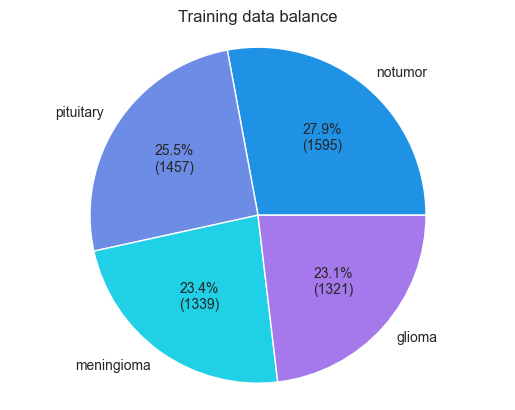

In [80]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")

plt.show()

In [81]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [82]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


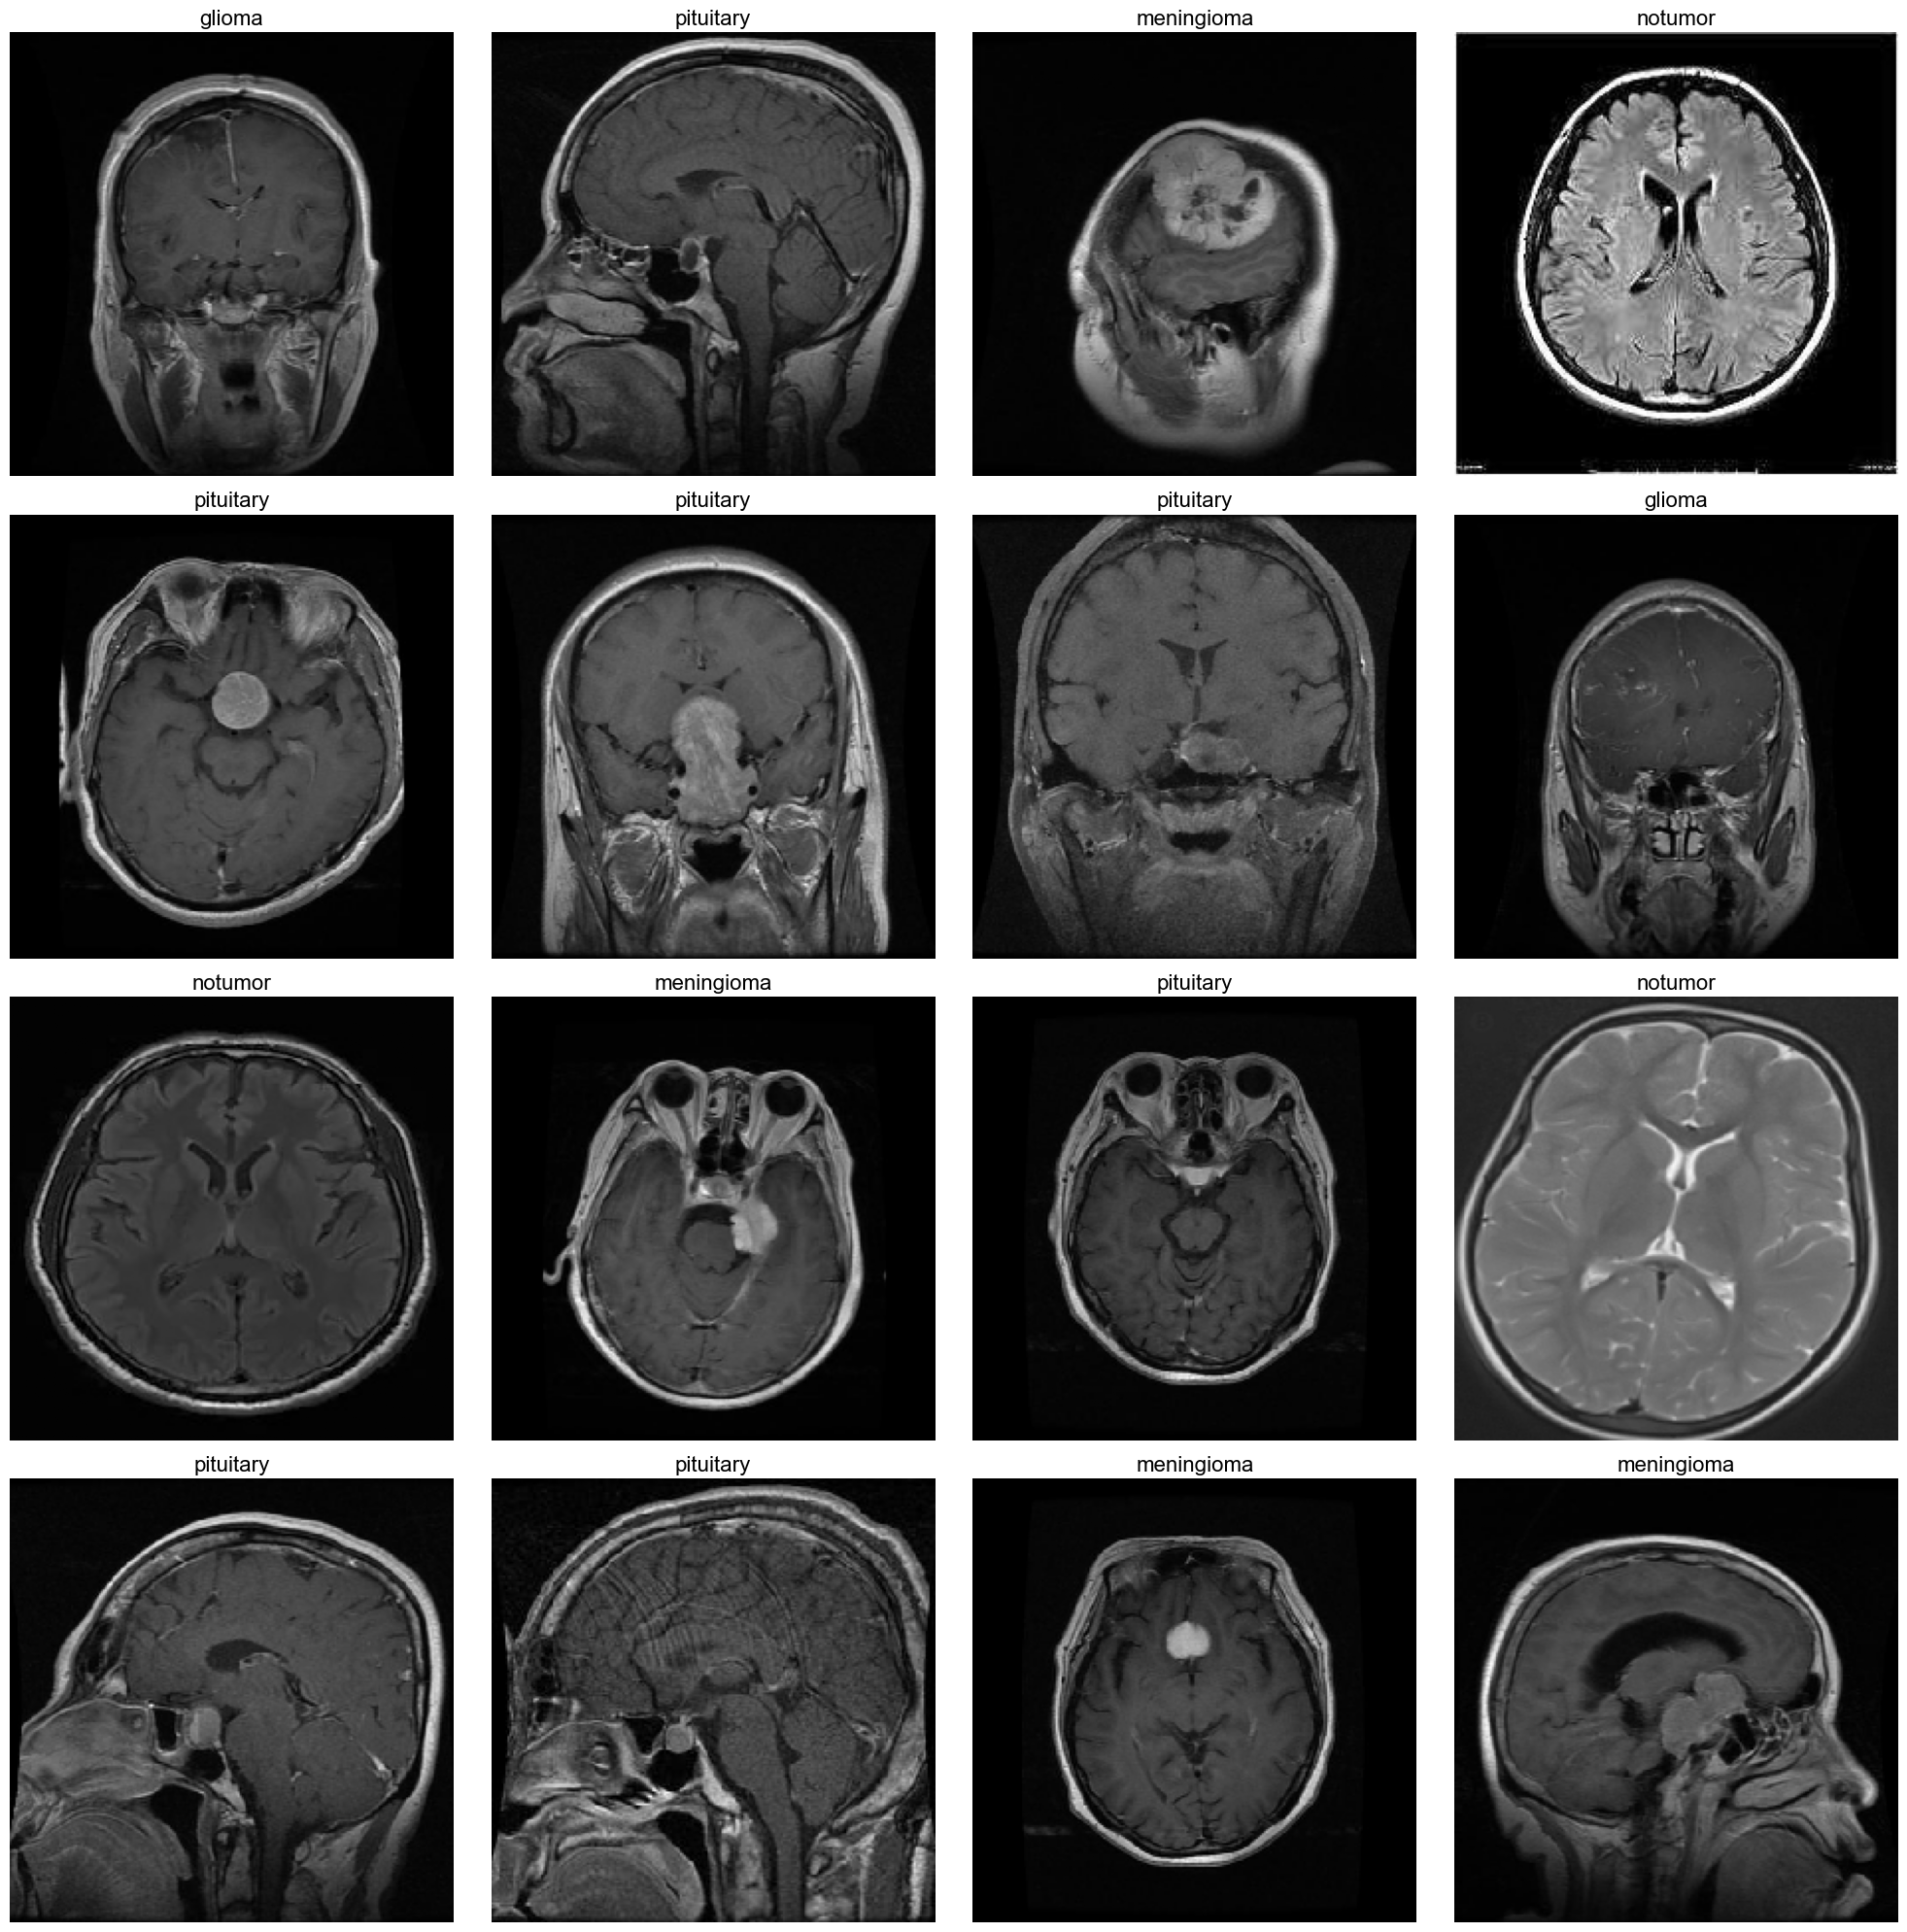

In [83]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [84]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))

In [85]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [86]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 [==============================] - 199s 552ms/step - loss: 9.0710 - accuracy: 0.7836 - val_loss: 0.4041 - val_accuracy: 0.8779
Epoch 2/10
357/357 [==============================] - 194s 544ms/step - loss: 0.2156 - accuracy: 0.9391 - val_loss: 0.1999 - val_accuracy: 0.9298
Epoch 3/10
357/357 [==============================] - 190s 532ms/step - loss: 0.0836 - accuracy: 0.9792 - val_loss: 0.2437 - val_accuracy: 0.9405
Epoch 4/10
357/357 [==============================] - 201s 562ms/step - loss: 0.0347 - accuracy: 0.9926 - val_loss: 0.1914 - val_accuracy: 0.9496
Epoch 5/10
357/357 [==============================] - 225s 631ms/step - loss: 0.0123 - accuracy: 0.9989 - val_loss: 0.1822 - val_accuracy: 0.9618
Epoch 6/10
357/357 [==============================] - 173s 484ms/step - loss: 0.0060 - accuracy: 0.9995 - val_loss: 0.1686 - val_accuracy: 0.9573
Epoch 7/10
357/357 [==============================] - 195s 545ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.1870 -

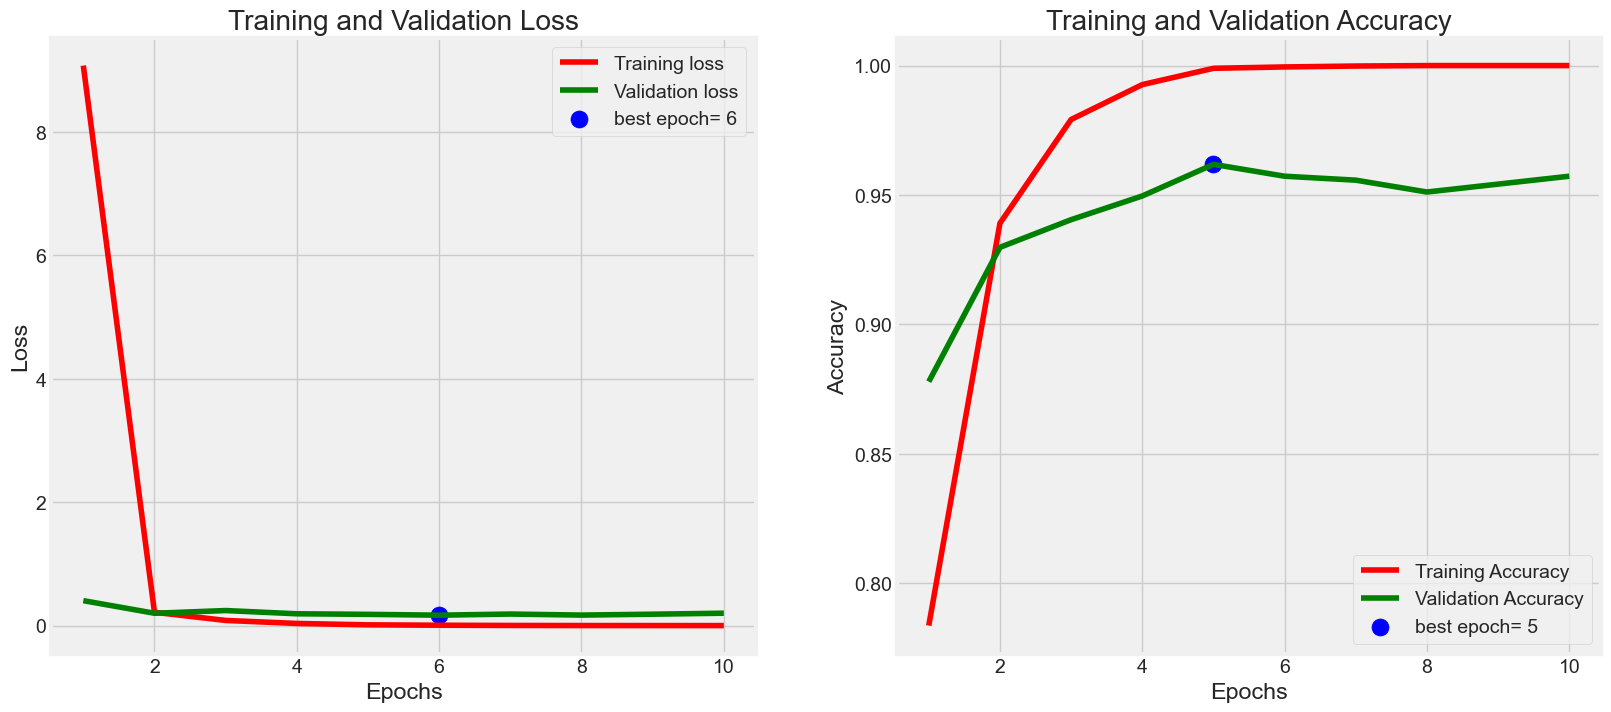

In [87]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [89]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 18s 433ms/step - loss: 0.3499 - accuracy: 0.9497
Train Loss:  0.00011359195923432708
Train Accuracy:  1.0
--------------------
Validation Loss:  0.20086826384067535
Validation Accuracy:  0.9572519063949585
--------------------
Test Loss:  0.3499075770378113
Test Accuracy:  0.9496951103210449


In [90]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

AttributeError: 'History' object has no attribute 'predict'

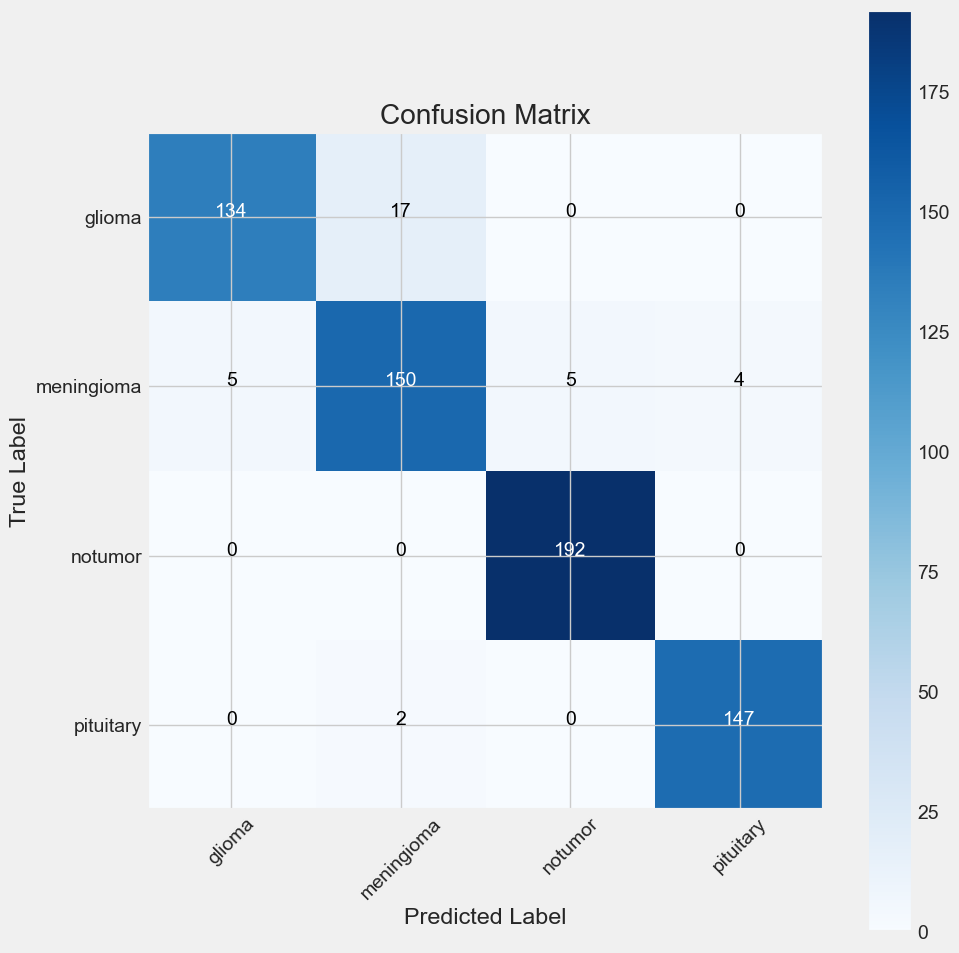

In [91]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [92]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.96      0.89      0.92       151
  meningioma       0.89      0.91      0.90       164
     notumor       0.97      1.00      0.99       192
   pituitary       0.97      0.99      0.98       149

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [93]:
#Save the model
model.save('C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/Brain Tumor.h5')

In [94]:
loaded_model = tf.keras.models.load_model('Brain Tumor.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

1/1 [==============================] - 0s 115ms/step
No Tumor


(-0.5, 223.5, 223.5, -0.5)

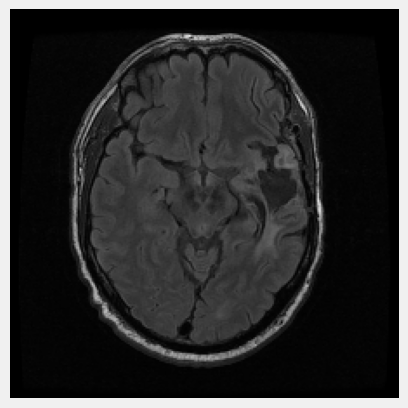

In [116]:
image_path = 'C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/dataset/Patient Data/p37/mri.jpg'
image = cv.imread(image_path)

# Preprocess the image
shape_array=image.shape
img=cv.resize(image,(224,224))
#img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print(f"{class_labels[np.argmax(predictions)]}")
plt.imshow(img,cmap='gray')
#plt.title(predicted)
plt.axis('off')

1/1 [==============================] - 1s 507ms/step
Glioma


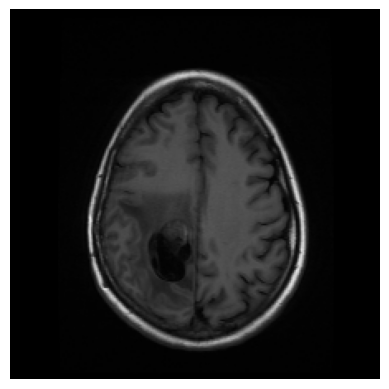

In [72]:
def classification():
    loaded_model = tf.keras.models.load_model('Brain Tumor.h5', compile=False)
    loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
    image=cv.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/dataset/Patient Data/p38/mri.jpg')   

    # Preprocess the image
    shape_array=image.shape
    img=cv.resize(image,(224,224))
    #img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    print(f"{class_labels[np.argmax(predictions)]}")
    plt.imshow(img,cmap='gray')
    #plt.title(predicted)
    plt.axis('off')
classification()
